# Reading unstructured VTK data from Paraview in Python3
D. Duke

Department of Mechanical & Aerospace Engineering

Monash University

This code demonstrates reading VTK data from Paraview, and then calculating the width of the PMDI spray.

In [1]:
import numpy as np
import time, os, glob

## High speed imaging data for comparison

In [2]:
D=0.33e-3
L=1.2e-3

expt={'134a':np.array([
    0.3399,    0.7142,
    1.4661,    1.5736,
    2.8450,    2.1426,
    3.8399,    2.3927,
    5.4146,    2.5961,
    6.9999,    2.7550,
    8.5976,    2.8615,
   10.1753,    3.0047,
   11.7683,    3.1172,
   14.5349,    3.1855,
   18.9386,    3.4024,
   21.3139,    3.4390,
   23.6781,    3.4472,
   26.0706,    3.6337,
   30.3906,    4.2241,
   33.1311,    4.4595,
   35.8777,    4.7291,
   38.6037,    5.0554,
   41.3564,    5.3407,
])}

expt['152a']=np.array([
    0.3704,    0.8844,
    1.4812,    1.8721,
    2.8431,    2.3995,
    3.8532,    2.6841,
    5.4429,    2.9654,
    7.0370,    3.2474,
    8.6452,    3.4285,
   10.2400,    3.5524,
   11.8350,    3.6409,
   14.5741,    3.7785,
   19.2151,    4.1120,
   21.7409,    4.2385,
   24.2518,    4.3197,
   26.7910,    4.6070,
   31.6654,    5.4682,
   34.6391,    5.8751,
   37.6131,    6.2940,
   40.5573,    6.7126,
   43.5312,    7.0396,
])

expt['1234ze']=np.array([
    0.3399,    0.7326,
    1.4517,    1.6728,
    2.8277,    2.2738,
    3.8634,    2.5504,
    5.4717,    2.8387,
    7.0891,    3.0778,
    8.7152,    3.2540,
   10.3267,    3.4765,
   11.9383,    3.6939,
   14.5663,    3.9343,
   19.2356,    4.4621,
   21.7881,    4.7255,
   24.3253,    4.9539,
   26.8926,    5.2616,
   31.5087,    6.2309,
   34.5031,    6.6828,
   37.4975,    7.1547,
   40.4613,    7.6712,
   43.4557,    8.2424,
])

## Load VTK File

In [3]:
import vtk
from vtk.util import numpy_support

In [4]:
vtu_data=glob.glob('*/*.vtu')
filename=vtu_data[4]
print(filename)

les_pmdimv2_0.33x1.2_ures_1234ze_smi/les_pmdimv2_0.33x1.2_ures_1234ze_smi_0_0.vtu


In [5]:
t0 = time.perf_counter()
sz = os.path.getsize(filename)
reader = vtk.vtkXMLUnstructuredGridReader()
reader.SetFileName(filename)
reader.Update()
output = reader.GetOutput()
t1 = time.perf_counter()
print("%s: read %0.1f MiB in %0.1f s" % (os.path.basename(filename),sz/1048576,t1-t0))

les_pmdimv2_0.33x1.2_ures_1234ze_smi_0_0.vtu: read 1372.0 MiB in 12.5 s


In [6]:
%matplotlib widget
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib import colormaps

In [7]:
# get the coordinates into human-readable variable names
coords = numpy_support.vtk_to_numpy(output.GetPointData().GetArray('Coords'))
radius = coords[:,0]
theta = coords[:,1]
z = coords[:,2]

In [8]:
v = numpy_support.vtk_to_numpy(output.GetPointData().GetArray('yMean'))
#v = 1 - v #np.log10(v)

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_68378/2662830877.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  p_=plt.pcolormesh(grid_z,grid_r,grid_v0)


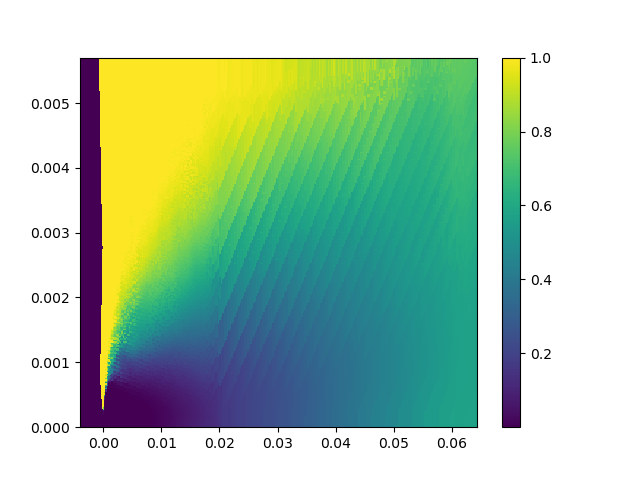

In [9]:
fig=plt.figure()
flt=(np.abs(coords[:,1]-0.25*np.pi)<0.1) # limit theta values
#p_=plt.scatter(coords[flt,2],coords[flt,0],marker='.',s=1,c=v[flt],cmap=colormaps['jet']);

r_bins = np.hstack(( np.linspace(0,D,64) ,  np.linspace(D/2,radius.max(),256) )) #np.linspace(radius.min(),radius.max(),128)
z_bins =  np.hstack(( np.linspace(z.min(),-L,32) , np.linspace(-L,L,64),  np.linspace(0,z.max(),256) )) # np.linspace(z.min(),z.max(),128)

grid_z, grid_r = np.meshgrid(z_bins, r_bins)
grid_v0 = griddata((z[flt], radius[flt]), v[flt], (grid_z, grid_r), method='nearest')
p_=plt.pcolormesh(grid_z,grid_r,grid_v0)

#p_=plt.scatter(grid_z,grid_r,marker='.',s=1,c=grid_v0)
#plt.gca().set_aspect('equal');
plt.colorbar(p_);


## Calculate width of spray

In [10]:
# divide z domain up into pieces that have sufficient samples in each.
# z_bins shows the z axis mid-points, and i_bins has a list of indices that fit into each.

dz_min = 5e-5
min_samples=2000
z_bins = []
i_bins = []
zm = z.min()
while zm <= z.max():
    #for zm in np.arange(z.min(),z.max(),dz):
    dz=dz_min
    flt = (z>zm-dz/2)&(z<zm+dz/2)
    while np.sum(flt)<min_samples:
        dz*=2
        flt = (z>zm-dz/2)&(z<zm+dz/2)
    z_bins.append(zm)
    i_bins.append(flt)
    zm += dz/2 + dz_min
z_bins=np.array(z_bins)

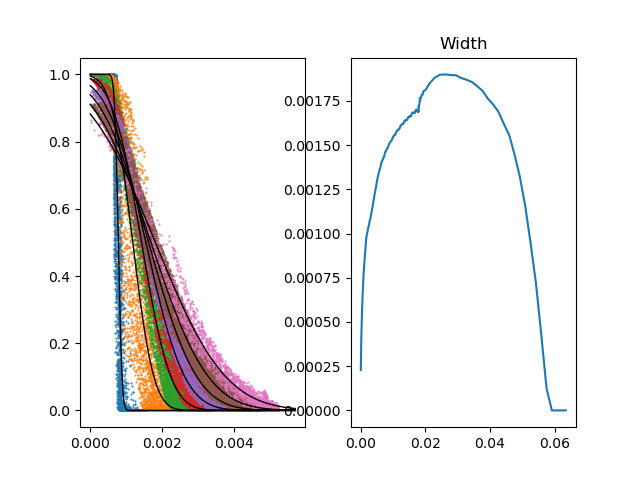

In [69]:
# Fit erfc to the mixing layer to 1-y(r) at each z position.
# Use this least-squares fit to find the threshold.
import scipy.special
from scipy.optimize import curve_fit

def func(z,b,c):
   return 0.5*(scipy.special.erf(b*z+c)+1)

# Get 1-y data
v = 1 - numpy_support.vtk_to_numpy(output.GetPointData().GetArray('yMean'))
# radii for interpolation
r__ = np.linspace(0,radius.max(),1024)
width = []
wall = []

# Diagnostic plot
fig, (ax1, ax2) = plt.subplots(1, 2)#, sharey=True)


for i in range(len(i_bins)):

    # Slice radius, 1-y data.
    r_ = radius[(i_bins[i])]
    v_ = v[(i_bins[i])]

    wall.append(np.nanmax(r_))
    
    if ~np.any(v_<0.5): # there must be a mixing layer
        width.append(np.nan)
    else:
        
        # Least-squares
        popt, pcov = curve_fit(func, r_, v_)
    
        # Interpolate to find threshold for width
        evaluatedFunction = func(r__,*popt)
        w__ = np.interp(0.5, evaluatedFunction[::-1], r__[::-1]) # must be monotonically increasing, so reversed.
        width.append( w__ )
    
        # Plot just a few cross-sections for sanity check
        if np.mod(i,40) == 0:
            ax1.scatter(r_,v_,marker='.',s=1)
            ax1.plot(r__,evaluatedFunction,c='k',lw=1)

# Save arrays.
width=np.array(width); wall=np.array(wall)

# Diagnostic plot.
ax2.set_title('Width')
ax2.plot(z_bins, width, label='width');
#ax2.plot(z_bins, wall, label='wall'); plt.legend();

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_68378/4055143929.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  p_=plt.pcolormesh(1e3*grid_z,1e3*grid_r,grid_v0,cmap=colormaps['jet'])


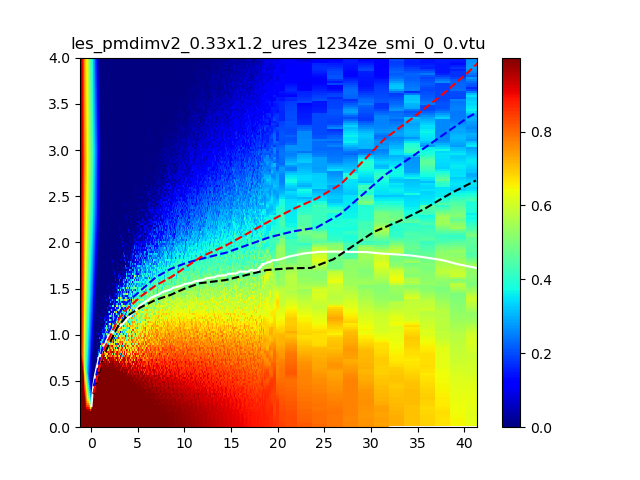

In [79]:
# Plot 1-y and overlay the width data calculated above.

fig=plt.figure()
plt.title(os.path.basename(filename))

flt=Ellipsis #(np.abs(coords[:,1]-0.25*np.pi)<.05) # limit theta values on surface-plot

grid_z, grid_r = np.meshgrid(z_bins, r_bins)
grid_v0 = griddata((z[flt], radius[flt]), v[flt], (grid_z, grid_r), method='linear')
p_=plt.pcolormesh(1e3*grid_z,1e3*grid_r,grid_v0,cmap=colormaps['jet'])

# Width as measured previously
plt.plot(1e3*grid_z[0,:], 1e3*width,c='w')

# Add experimental spray half-width
plt.plot(expt['134a'][::2]  -0.1 , .5*expt['134a'][1::2], c='k', ls='--', label='Expt. HFA134a')
plt.plot(expt['152a'][::2]  -0.1, .5*expt['152a'][1::2], c='b', ls='--', label='Expt. HFA152a')
plt.plot(expt['1234ze'][::2]-0.1, .5*expt['1234ze'][1::2], c='r', ls='--', label='Expt. HFO1234ze(E)')

plt.xlim(1e3*-L,expt['134a'][::2].max());
plt.ylim(0, 4);
plt.colorbar(p_);

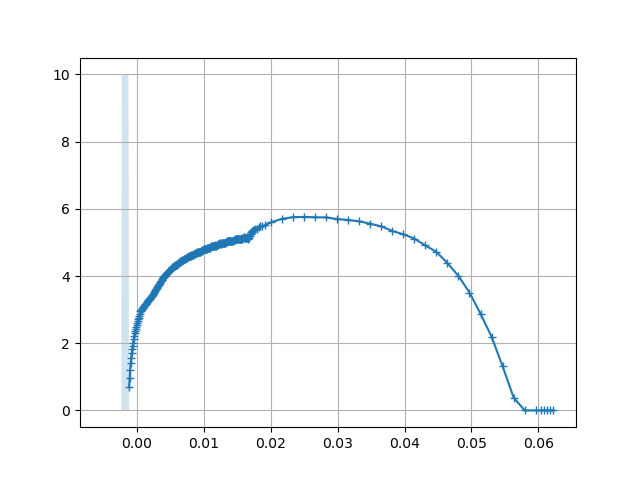

In [77]:
plt.figure()
in_noz = wall<=D + 1e-6
#plt.xscale('log')
plt.fill_between(z_bins - L, 0*in_noz, in_noz*10, alpha=.2)
#plt.plot(z_bins - L, wall/D)
plt.plot(z_bins - L,width/D,marker='+');
plt.grid();